<a href="https://colab.research.google.com/github/fweberling/Gaussian_Processes/blob/master/Neural_Networks_as_Gaussian_Processes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numpy.linalg import inv


import seaborn as sns
#from gp import Gaussian_Process
#from covariance_function import Covariance_function

In [ ]:
# Test inputs
num_test_samples = 100
X_test = np.linspace(-4, 4, num_test_samples).reshape(num_test_samples,1)
X_test_brown = np.linspace(0, 8, num_test_samples).reshape(num_test_samples,1)

In [ ]:
def get_covariance_matrix(X_p, X_q, covariance_function, visualize = True):
        
        covariance_matrix = np.zeros((X_p.shape[0], X_q.shape[0]))

        for i in np.arange(X_p.shape[0]):
            for j in np.arange(X_q.shape[0]):
                covariance_matrix[i,j] = covariance_function(X_p[i], X_q[j])
        
        if visualize == True:
            sns.heatmap(covariance_matrix)
                
        return covariance_matrix

# Covariance Functions / Kernels

#### Squared exponential 

\begin{equation}
k\left(x_p, x_q \right) = \sigma_f^2 \mathrm{exp}\left(- \frac{1}{2l^2} \left(x_p - x_q\right)^2 \right)
\end{equation}

In [ ]:
def squared_exponential(x_p, x_q, signal_variance = 1.0, length_scale = 1.0):
    """"
    Squared-exponential covariance function calculating the covariance matrix

    X_p is (m x n) matrix
    """
    squared_dist = x_p.T @ x_p - 2 * x_p.T @ x_q + x_q.T @ x_q
    covariance = signal_variance * np.exp(- 1 / (2 * length_scale ** 2) * squared_dist)

    return covariance

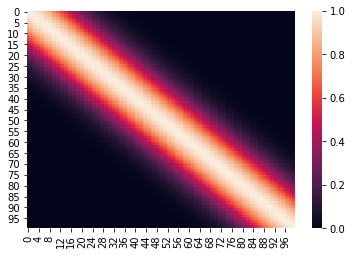

In [ ]:
cov_matrix = get_covariance_matrix(X_test, X_test, squared_exponential, visualize = True)

#### Brownian motion

\begin{equation}
k \left(x_p, x_q \right) = \mathrm{min}\left(x_p, x_q\right)
\end{equation}

In [ ]:
def brownian_motion(x_p, x_q):
    covariance = np.minimum(x_p, x_q)
    
    return covariance

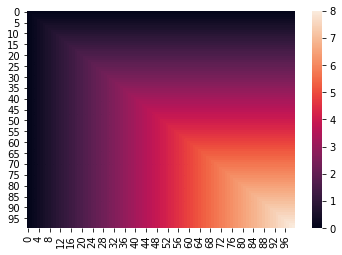

In [ ]:
cov_matrix = get_covariance_matrix(X_test_brown,X_test_brown, brownian_motion, visualize = True)

#### Neural Network


\begin{equation}
k \left(\pmb{x}, \pmb{x}' \right) = \frac{2}{\pi}\mathrm{sin}^{-1}\left( \frac{2 \tilde{\pmb{x}}^T \pmb{\Sigma}\tilde{\pmb{x}}'}{ \sqrt{\left(1 + 2 \tilde{\pmb{x}}^T \pmb{\Sigma}\tilde{\pmb{x}} \right)\left(1 + 2 \tilde{\pmb{x}}'^T \pmb{\Sigma}\tilde{\pmb{x}}'\right)}}  \right)
\end{equation}

with $\tilde{\pmb{x}} = \left[1, \pmb{x}^T \right]^T$

In [ ]:
def neural_network(x_p, x_q, bias_var = 4, weight_var = 100):
    
    x_p_tilde = np.vstack((1,x_p))
    x_q_tilde = np.vstack((1,x_q))
    
    weight_prior = np.array([[bias_var, 0], [0, weight_var]])
    
    theta = (2 * x_p_tilde.T @ weight_prior @ x_q_tilde) / (np.sqrt((1 + 2 * x_p_tilde.T @ weight_prior @ x_p_tilde) * 
                           (1 + 2* x_q_tilde.T @ weight_prior @ x_q_tilde)))
    
    theta = np.clip(theta, -1,1)
    covariance = 2/np.pi * np.arcsin(theta)
    
    return covariance

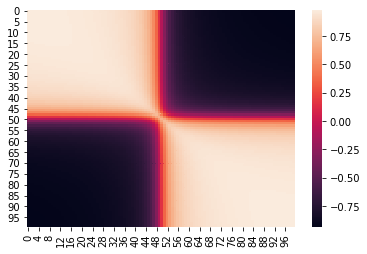

In [ ]:
cov_matrix = get_covariance_matrix(X_test, X_test, neural_network, visualize = True)

# Priors

In [ ]:
def plot_gaussian_process(X_test, mean, covariance_matrix, num_samples):
    
    samples = np.random.multivariate_normal(mean, covariance_matrix,1).reshape(X_test.size,1)

    for func in range(1, num_samples):
        sample = np.random.multivariate_normal(mean, covariance_matrix,1).reshape(X_test.size,1)
        samples = np.hstack((samples, sample))

    # Plotting samples
    fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
    ax.plot(X_test, samples,'-', label = 'sample')
    #ax.legend(loc = 'lower left')
    plt.title('Gaussian Process Prior')
    plt.show()

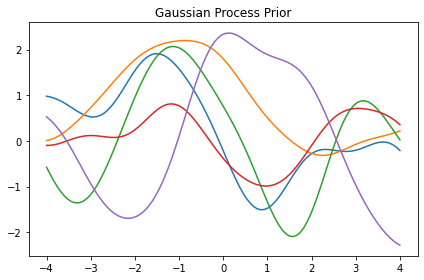

In [ ]:
covariance_matrix = get_covariance_matrix(X_test, X_test, squared_exponential, visualize = False)
mean = np.zeros(X_test.shape[0])

plot_gaussian_process(X_test, mean, covariance_matrix, 5)

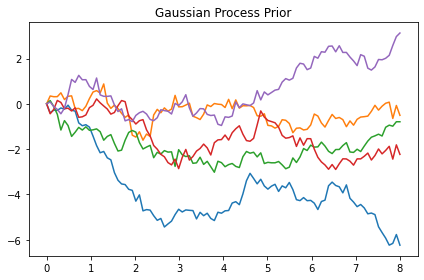

In [ ]:
covariance_matrix = get_covariance_matrix(X_test_brown, X_test_brown, brownian_motion, visualize = False)
mean = np.zeros(X_test_brown.shape[0])

plot_gaussian_process(X_test_brown, mean, covariance_matrix, 5)

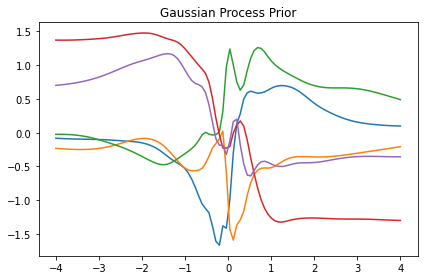

In [ ]:
covariance_matrix = get_covariance_matrix(X_test,X_test, neural_network, visualize = False)
mean = np.zeros(X_test.shape[0])

plot_gaussian_process(X_test, mean, covariance_matrix, 5)

# Training Data

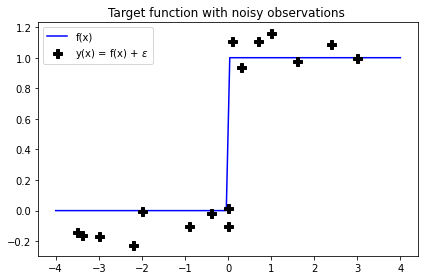

In [ ]:
# Noise free training inputs
X_train = np.array([-3.5, -3.4, -3,-2.2, -2, -0.9,-0.4, -0.01,0,0.1, 0.3,0.7, 1, 1.6 , 2.4, 3.0]).reshape(-1,1)
#f_train = np.cos(X_train) 
f_train = np.heaviside(X_train, 0)

# Noise-free training outputs
#f = np.cos(X_test)
f = np.heaviside(X_test, 0)

# Noisy training Inputs with additive Gaussian noise (zero-mean, variance sigma_n)
sigma_n = 0.1

mu = np.zeros(X_train.size)
epsilon = np.random.multivariate_normal(mu, sigma_n**2 * np.eye(X_train.size))

# Noisy targets
y_train = f_train + epsilon.reshape(X_train.size,1)

# Noisy observations
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(X_test, f, 'b', label = 'f(x)')
ax.plot(X_train, y_train, 'kP', ms = 9, label = 'y(x) = f(x) + $\epsilon$')
ax.legend(loc = 'upper left')
ax.set_title('Target function with noisy observations ')

plt.show()

In [ ]:
def predictive_distribution(X_test, X_train, y_train, sigma_n, covariance_function):
    """
    Calculates the mean and the covariance matrix of the predictive distribution
    
    """
    
    # Covariance matrix of training/ training
    K_traintrain = get_covariance_matrix(X_train, X_train, covariance_function, visualize = False) + sigma_n**2 * np.eye((get_covariance_matrix(X_train, X_train, covariance_function, visualize = False)).shape[0])

    # Covariance matrix of training / testing
    K_traintest = get_covariance_matrix(X_train, X_test, covariance_function, visualize = False)

    # Covariance matrix of testing / training
    K_testtrain = get_covariance_matrix(X_test, X_train, covariance_function, visualize = False)

    # Covariance matrix of testing / testing
    K_testtest = get_covariance_matrix(X_test, X_test, covariance_function, visualize = False)

    # Mean of predictive distribution
    f_mean = K_testtrain @ inv(K_traintrain) @ y_train

    # Covariance matrix of predictive distribution
    f_cov = K_testtest - K_testtrain @ inv(K_traintrain) @ K_traintest
    
    L_traintrain = np.linalg.cholesky(K_traintrain + sigma_n**2 * np.eye(K_traintrain.shape[0]))
    L_traintest = np.linalg.solve(L_traintrain, K_traintest)

    var = np.diag(K_testtest) - np.sum(L_traintest**2, axis=0)
    stdv = np.sqrt(var)
    
    return f_mean, f_cov, stdv

In [ ]:
def generate_samples(mean, covariance_matrix, num_samples):
    
    samples = np.random.multivariate_normal(mean, covariance_matrix,1).reshape(mean.size,1)

    for func in range(1, 5):
        sample = np.random.multivariate_normal(mean, covariance_matrix,1).reshape(mean.size,1)
        samples = np.hstack((samples, sample))
        
    return samples
    

In [ ]:
# GP with Squared Exponential Kernel
prior_cov = get_covariance_matrix(X_test,X_test, squared_exponential, visualize = False)
#prior_cov = get_covariance_matrix(X_test,X_test, neural_network, visualize = False)

prior_mean = np.zeros(X_test.shape[0])

prior_samples = generate_samples(prior_mean, prior_cov, 5)

# Posterior GP
f_mean, f_cov, stdv = predictive_distribution(X_test, X_train, y_train, sigma_n, squared_exponential)
#f_mean, f_cov, stdv = predictive_distribution(X_test, X_train, y_train, sigma_n, neural_network)

posterior_samples = generate_samples(f_mean.reshape(num_test_samples,), f_cov, 5)

Text(0.5, 1.0, 'Gaussian Process Predictive Distribution')

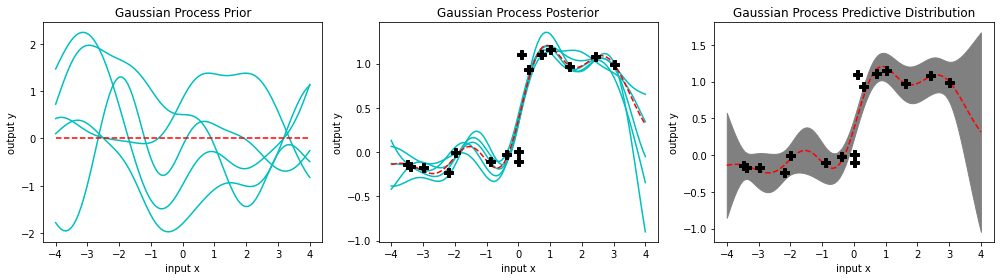

In [ ]:
fig, (axs) = plt.subplots(1, 3, figsize=(14, 4), tight_layout= True)

# Plot prior GP
axs[0].plot(X_test, prior_samples,'c', label = 'f_prior_sample')
axs[0].plot(X_test, prior_mean, 'r--', label = 'f_mean')
#axs[0,0].fill_between(X_test.flat, f_mean_noise_free.reshape(X_test.size) - 2 * stdv_noise_free, f_mean_noise_free.reshape(X_test.size) + 2 * stdv_noise_free, color="whitesmoke")
#axs[0,0].legend(loc = 'upper left')
axs[0].set_xlabel('input x')
axs[0].set_ylabel('output y')
axs[0].set_title('Gaussian Process Prior')

# Plot posterior GP
axs[1].plot(X_test, posterior_samples,'c', label = 'f_post_sample')
axs[1].plot(X_test, f_mean, 'r--', label = 'f_mean')
axs[1].plot(X_train, y_train,'kP', ms = 9, label = 'y(x) = f(x) + $\epsilon$')
#axs[0,1].fill_between(X_test.flat, f_mean.reshape(X_test.size) - 2 * stdv, f_mean.reshape(X_test.size) + 2 * stdv, color="whitesmoke")
#axs[0,1].legend(loc = 'upper left')
axs[1].set_xlabel('input x')
axs[1].set_ylabel('output y')
axs[1].set_title('Gaussian Process Posterior')

# Plot predictive GP
axs[2].plot(X_test, f_mean, 'r--', label = 'f_mean')
axs[2].plot(X_train, y_train,'kP', ms = 9, label = 'y(x) = f(x) + $\epsilon$')
axs[2].fill_between(X_test.flat, f_mean.reshape(X_test.size) - 2 * stdv, f_mean.reshape(X_test.size) + 2 * stdv, color="grey")
#axs[0,2].legend(loc = 'upper left')
axs[2].set_xlabel('input x')
axs[2].set_ylabel('output y')
axs[2].set_title('Gaussian Process Predictive Distribution')


In [ ]:
# GP One-Hidden-Layer Neural Network Kernel
prior_cov = get_covariance_matrix(X_test,X_test, neural_network, visualize = False)

prior_mean = np.zeros(X_test.shape[0])

prior_samples = generate_samples(prior_mean, prior_cov, 5)

# Posterior GP
f_mean, f_cov, stdv = predictive_distribution(X_test, X_train, y_train, sigma_n, neural_network)

posterior_samples = generate_samples(f_mean.reshape(num_test_samples,), f_cov, 5)

Text(0.5, 1.0, 'Gaussian Process Predictive Distribution')

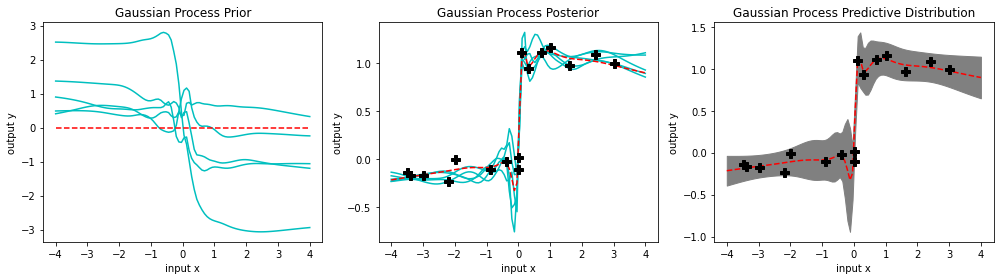

In [ ]:
fig, (axs) = plt.subplots(1, 3, figsize=(14, 4), tight_layout= True)

# Plot prior GP
axs[0].plot(X_test, prior_samples,'c', label = 'f_prior_sample')
axs[0].plot(X_test, prior_mean, 'r--', label = 'f_mean')
#axs[0,0].fill_between(X_test.flat, f_mean_noise_free.reshape(X_test.size) - 2 * stdv_noise_free, f_mean_noise_free.reshape(X_test.size) + 2 * stdv_noise_free, color="whitesmoke")
#axs[0,0].legend(loc = 'upper left')
axs[0].set_xlabel('input x')
axs[0].set_ylabel('output y')
axs[0].set_title('Gaussian Process Prior')

# Plot posterior GP
axs[1].plot(X_test, posterior_samples,'c', label = 'f_post_sample')
axs[1].plot(X_test, f_mean, 'r--', label = 'f_mean')
axs[1].plot(X_train, y_train,'kP', ms = 9, label = 'y(x) = f(x) + $\epsilon$')
#axs[0,1].fill_between(X_test.flat, f_mean.reshape(X_test.size) - 2 * stdv, f_mean.reshape(X_test.size) + 2 * stdv, color="whitesmoke")
#axs[0,1].legend(loc = 'upper left')
axs[1].set_xlabel('input x')
axs[1].set_ylabel('output y')
axs[1].set_title('Gaussian Process Posterior')

# Plot predictive GP
axs[2].plot(X_test, f_mean, 'r--', label = 'f_mean')
axs[2].plot(X_train, y_train,'kP', ms = 9, label = 'y(x) = f(x) + $\epsilon$')
axs[2].fill_between(X_test.flat, f_mean.reshape(X_test.size) - 2 * stdv, f_mean.reshape(X_test.size) + 2 * stdv, color="grey")
#axs[0,2].legend(loc = 'upper left')
axs[2].set_xlabel('input x')
axs[2].set_ylabel('output y')
axs[2].set_title('Gaussian Process Predictive Distribution')